## Teste no Dataset de Vídeos

Nesta etapa iremos testar nossos modelos treinados no dataset de imagens no dataset de vídeos e ver seu resultado.

In [2]:
import cv2

import random

import pandas as pd

from facenet_pytorch import MTCNN

from fastai.vision import *

from PIL import Image
import glob, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from IPython.core import display as ICD

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Definimos um device onde a validação será rodada.

In [3]:
# Definimos um device onde os tensors estarão sendo processados
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


Vamos carregar um modelo ResNet18 treinado pelo fastai. Como a preferência na hora da inferência é de utilizar o PyTorch ao invés do FastAI, cria-se uma função para recuperar o modelo no formato PyTorch.

In [4]:
def fastai_to_pytorch(base_model, path):
    classes = ['FAKE', 'REAL']
    aux_data = ImageDataBunch.single_from_classes(path='.', classes=classes)
    learn = cnn_learner(aux_data, base_model)
    learn.load(path)
    
    return learn, learn.model

Carrega-se uma Resnet18 treinada.

In [5]:
base_path = '../Faces Dataset/no-resize-color/models/'
file_name = 'resnet18_best_mcc_unfreezed_fold1'
base_model = models.resnet18

ftp = fastai_to_pytorch(base_model, base_path + file_name)
resnet18_learn = ftp[0]
resnet18 = ftp[1]

Criamos uma lista de todos as pastas que contém os vídeos para testar.

In [6]:
# Cria uma lista de todas as pastas disponíveis para treinamento
folders = next(os.walk('./Kaggle Dataset/'))[1]
folders[:10]

['dfdc_train_part_0',
 'dfdc_train_part_1',
 'dfdc_train_part_10',
 'dfdc_train_part_11',
 'dfdc_train_part_12',
 'dfdc_train_part_13',
 'dfdc_train_part_14',
 'dfdc_train_part_15',
 'dfdc_train_part_16',
 'dfdc_train_part_17']

Definimos algumas classes e funções para nos auxiliar.

Classe **Videos**

In [7]:
# Cuida de lidar com o acesso aos vídeos e devolver os paths / labels corretamente
class Videos():
    def __init__(self, folder_path):
        # Guarda o folder_path
        self.folder_path = folder_path
        
        # Guarda a lista de todos os arquivos de videos dentro do folder_path
        self.video_files = glob.glob(folder_path + '/*.mp4')
        
        # Lê o arquivo JSON que contém as informações dos deepfakes naquela pasta
        self.metadata = pd.read_json(folder_path + '/metadata.json').transpose() # Essa transposiçao eh feita pois as colunas e as linhas estao trocadas
        
    def getRandomVideo(self):
        video_path = random.choice(self.video_files)
        video_name = os.path.basename(video_path)
        label = self.metadata.loc[video_name].label
        
        return video_path, video_name, label
        
    def getRealVideo(self, video_name):
        real_video_name = self.metadata.loc[video_name].original
        # Verifica se é NaN, pois caso seja o nome original é o próprio video real
        if pd.isna(real_video_name):
            real_video_name = video_name
        real_video_path = folder_path + '/' + real_video_name
        return real_video_path, real_video_name, 'REAL'
    
    def getAllVideosPath(self):
        for video_name, columns in self.metadata.iterrows():
            yield self.folder_path + '/' + video_name, video_name, columns[0] # Label

def getYUVTensor(face, size, transform):
    face = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
    face = cv2.resize(face, (size, size))[:, :, 0]
    face_tensor = transform(face)
    face_tensor = torch.cat((face_tensor, face_tensor, face_tensor)).unsqueeze(0)
    return face_tensor

Função **showVideo**

In [8]:
def showVideo(video_path, label="FAKE", padding=0, size=-1, channel=None, separate_face_box=False, resize_factor=0.6):
    
    if not os.path.isfile(video_path):
        print("Caminho não existe.")
        return
    
    cap = cv2.VideoCapture(video_path)
    
    # Configura a cor a ser colocada na LABEL
    if label == 'REAL':
        color = (0, 255, 0) # Verde
    else:
        color = (0, 0, 255) # Vermelho  
    
    face = None
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            boxes, _ = mtcnn.detect(Image.fromarray(frame))
            if boxes is not None:
                for box in boxes: 
                    face = frame[int(box[1] - padding):int(box[3] + padding), int(box[0] - padding):int(box[2] + padding)].copy()
                    cv2.putText(img=frame, text=label, org=(box[0], box[1]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=color, thickness=2)
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color=[0, 255, 0], thickness=5)
                    if channel == 'luma':
                        face = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
                        face = face[:,:,0] # Pega apenas o canal Y
                    
            if face is not None:
                if size > 0:
                    face = cv2.resize(face, (size, size))
                
                if separate_face_box:
                    cv2.imshow('face', face)
            
            frame = cv2.resize(frame, (int(frame.shape[1]*resize_factor), int(frame.shape[0]*resize_factor)))
            cv2.imshow('frame', frame)
            
            # Apertar a tecla 'q' para sair do vídeo.
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        else:
            cv2.destroyAllWindows()
            break

    cap.release()
    cv2.destroyAllWindows()

Classe **Predictor**

In [9]:
class Predictor():
    
    def __init__(self, model, batch_size, padding, size, check_every_frame):
        self.model = model.to(device)
        self.model.eval()
        
        self.classes = {0: "FAKE", 1: "REAL"}
        self.batch_size = batch_size
        self.padding = padding
        self.size = size
        self.check_every_frame = check_every_frame
        self.video_path = None
        self.faces_list = None
        self.faces_tensor = None
        self.predicts_tensor = None
        self.final_predict = None
    
    def setVideoPath(self, video_path):
        if not os.path.isfile(video_path):
            print("Caminho não encontrado.")
            return
        self.video_path = video_path
        self.faces_list = None
        self.faces_tensor = None
        self.predicts_tensor = None
        self.final_predict = None
        return
    
    def getFacesTensor(self):
        if self.video_path is None:
            print("Por favor, utilize a função setVideoPath() para indicar o caminho para um vídeo.")
            return
        # Instancia um VideoCapture do arquivo presente em video_path (no caso, o vídeo)
        cap = cv2.VideoCapture(self.video_path)
        # Pega, em inteiros, a quantidade de frames do vídeo
        v_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Inicializa frames como uma lista vazia
        frames = []
        self.faces_list = []

        # Entra num loop que percorre o vídeo até ele acabar
        for _ in range(1, v_len + 1):
            # Realiza um grab() no próximo frame, mas não o decodifica. Isso ajuda a agilizar o processo se não for necessário
            # recuperar todos os frames a todo o momento.
            success = cap.grab()
            # Só recorta o rosto se o frame atual for mod check_every_frame, ou seja, ele só decodifica de check_every_frame em check_every_frame frames.
            if _ == 1 or _ % self.check_every_frame == 0:
                success, frame = cap.retrieve()
            else:
                continue
            if not success:
                continue

            # Realiza um append do frame atual na lista frames
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frames.append(frame)

            if len(frames) >= self.batch_size or (_ == v_len and len(frames) > 0):
                # Utiliza o MTCNN para detectar todas as bounding boxes de todos os rostos
                boxes, probs = mtcnn.detect(frames)
                # Verifica se não foi obtida nenhuma bounding box em todo o batch
                if not all(x is None for x in boxes):
                    # Acessa cada um dos frames no batch
                    for i, boxes_f in enumerate(boxes):
                        # Verifica houve None para o frame atual
                        if boxes_f is not None:
                            # Acessa cada uma das bounding boxes dentro de um único frame (pode haver vários rostos)
                            face_count = 0
                            for bbox in boxes_f:
                                face = frames[i].crop(box=(bbox[0]-self.padding, 
                                                           bbox[1]-self.padding, 
                                                           bbox[2]+self.padding, 
                                                           bbox[3]+self.padding))


                                # Se desejado, aplica um resize
                                if self.size > 0:
                                    face = face.resize((self.size, self.size))

                                self.faces_list.append(face)

                frames = []

        # Solta o objeto do VideoCapture
        cap.release()

        #transform = transforms.Compose([transforms.ToTensor(), 
        #                                transforms.Normalize(imagenet_stats[0],
        #                                                     imagenet_stats[1])])
        
        transform = transforms.ToTensor()
        
        all_faces_tensor = torch.tensor([])

        for face in self.faces_list:
            face_tensor = transform(face).unsqueeze(0)
            all_faces_tensor = torch.cat((all_faces_tensor, face_tensor), dim=0)
        
        self.faces_tensor = all_faces_tensor.to(device)
        
        return self.faces_tensor
    
    def getPredictsTensor(self):
        if self.faces_tensor is None:
            if self.getFacesTensor() is None:
                return

        with torch.no_grad():
            if len(self.faces_tensor) > 0:
                self.predicts_tensor = F.softmax(resnet18(self.faces_tensor), dim=1)
            else:
                return
            
        return self.predicts_tensor
    
    def getFinalPredict(self, strategy='majority'):
        if self.predicts_tensor is None:
            if self.getPredictsTensor() is None:
                return 
        
        if strategy == 'majority':
            fp = lambda tensor: tensor[1].argmax(dim=0).item() if len(tensor[0]) != 1 else unique[0].item()

            unique = self.predicts_tensor.argmax(dim=1).unique(return_counts=True)

            self.final_predict = fp(unique)

            return self.final_predict, self.classes[self.final_predict]
        
        else:
            return None

Definimos também nossa rede MTCNN idêntica à utilizada para retirar os rostos.

In [10]:
# Margin não faz diferença se o método .detect() for utilizado
IMAGE_SIZE = 224
MARGIN = 0
MIN_FACE_SIZE = 100
THRESHOLDS = [0.78, 0.78, 0.78]
POST_PROCESS = False
SELECT_LARGEST = False
KEEP_ALL = True
DEVICE = device

# ----------------------------------

mtcnn = MTCNN(image_size=IMAGE_SIZE,
              margin=MARGIN, 
              min_face_size=MIN_FACE_SIZE, 
              thresholds=THRESHOLDS,
              post_process=POST_PROCESS,
              select_largest=SELECT_LARGEST, 
              keep_all=KEEP_ALL, 
              device=device)

## Definimos um Predictor

A classe `Predictor()` ajudará a predizer um vídeo sendo FAKE ou REAL. Passamos para ele parâmetros a serem utilizados nos vídeos como o modelo, o batch_size, o padding, etc.

In [11]:
predictor = Predictor(resnet18, batch_size=20, padding=10, size=224, check_every_frame=5)

## Pasta Aleatória

Coletamos uma pasta aleatória de vídeos para o teste.

In [55]:
# Definimos a coleta de uma pasta aleatória
random_folder = random.choice(folders) + '/'

folder_path = './Kaggle Dataset/' + random_folder

# Instaciamos uma classe de Videos
videos = Videos(folder_path)
random_folder

'dfdc_train_part_46/'

## Teste vídeo FAKE

Obtemos um vídeo aleatório falso.

In [99]:
fake_video_path, fake_video_name, label = videos.getRandomVideo()
showVideo(fake_video_path, label)

Utilizamos o `video_path` no objeto `predictor` para que as predições possam ser feitas.

In [100]:
predictor.setVideoPath(fake_video_path)

Obtemos então a lista de rostos e o tensor de rostos tomados `check_every_frame`.

torch.Size([67, 3, 224, 224])


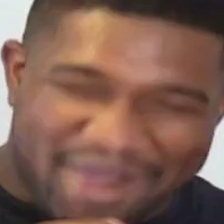

In [101]:
predictor.getFacesTensor()

print(predictor.faces_tensor.shape)
predictor.faces_list[0]

Passamos o Batch de rostos pelo modelo e então obtemos o tensor de predições.

In [102]:
predictor.getPredictsTensor()

predictor.predicts_tensor[:5]

tensor([[1.0000e+00, 3.1799e-08],
        [9.9999e-01, 5.8529e-06],
        [9.9963e-01, 3.6931e-04],
        [1.0000e+00, 5.3120e-08],
        [1.0000e+00, 1.9787e-06]], device='cuda:0')

Por fim analisamos o tensor de predições dada uma estratégia e obtemos a predição final.

In [103]:
predictor.getFinalPredict(strategy='majority')

(0, 'FAKE')

In [104]:
F.softmax(predictor.predicts_tensor, dim=1).argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

## Teste vídeo REAL

Refazemos os passos anteriores mas agora para a versão original do vídeo anterior.

In [105]:
real_video_path, real_video_name, label = videos.getRealVideo(fake_video_name)
showVideo(real_video_path, label)

E novamente realiza-se as predições em cima dele.

In [106]:
predictor.setVideoPath(real_video_path)
predictor.getFinalPredict(strategy='majority')

(1, 'REAL')

In [107]:
F.softmax(predictor.predicts_tensor, dim=1).argmax(dim=1)

tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

## Pipeline de Predição de Vídeos

Vamos utilizar o `Pandas` para isso. Criaremos uma entrada em uma tabela para cada vídeo avaliado no dataset.

In [33]:
predicts_df = pd.DataFrame(columns=["FOLDER", "True FAKE", "True REAL", "False FAKE", "False REAL"])
predicts_df.index.name = 'Video Name'
predicts_df 

,FOLDER,True FAKE,True REAL,False FAKE,False REAL
Video Name,,,,,


Vamos utilizar o exemplo do vídeo anterior e inserir a informação do vídeo na tabela.

In [34]:
predictor.setVideoPath(fake_video_path)

new_row = {"FOLDER": random_folder, "True FAKE": 0, "True REAL": 0, "False FAKE": 0, "False REAL": 0}
new_row["FOLDER"] = random_folder

label = "FAKE"
if predictor.getFinalPredict(strategy='majority')[1] == label:
    prefixo = "True "
else:
    prefixo = "False "
    
new_row[prefixo+label] = 1

predicts_df.loc[fake_video_name] = new_row
predicts_df

,FOLDER,True FAKE,True REAL,False FAKE,False REAL
Video Name,,,,,
yumwuqnwts.mp4,dfdc_train_part_4/,1,0,0,0


In [35]:
predictor.setVideoPath(real_video_path)

new_row = {"FOLDER": random_folder, "True FAKE": 0, "True REAL": 0, "False FAKE": 0, "False REAL": 0}
new_row["FOLDER"] = random_folder

label = "REAL"
if predictor.getFinalPredict(strategy='majority')[1] == label:
    prefixo = "True "
else:
    prefixo = "False "
    
new_row[prefixo+label] = 1

predicts_df.loc[real_video_name] = new_row
predicts_df

,FOLDER,True FAKE,True REAL,False FAKE,False REAL
Video Name,,,,,
yumwuqnwts.mp4,dfdc_train_part_4/,1,0,0,0
hvplvgwjzt.mp4,dfdc_train_part_4/,0,1,0,0


## Loop de Predição

Com o `DataFrame` neste formato, podemos por fim rodar o programa para todos os vídeos de todas as pastas. Levará de algumas horas a alguns dias para ser concluído.

In [22]:
#predicts_df = pd.DataFrame(columns=["FOLDER", "True FAKE", "True REAL", "False FAKE", "False REAL", "None"])
#predicts_df.index.name = 'Video Name'
#predicts_df

In [36]:
predicts_df = pd.read_csv('./Videos Predictions .csv/predicts_df.csv', index_col='Video Name')
predicts_df.head()

,FOLDER,True FAKE,True REAL,False FAKE,False REAL,None
Video Name,,,,,,
owxbbpjpch.mp4,dfdc_train_part_0,1,0,0,0,0
vpmyeepbep.mp4,dfdc_train_part_0,0,1,0,0,0
fzvpbrzssi.mp4,dfdc_train_part_0,0,0,0,1,0
htorvhbcae.mp4,dfdc_train_part_0,1,0,0,0,0
fckxaqjbxk.mp4,dfdc_train_part_0,1,0,0,0,0


In [230]:
# Inicializa-se um predictor e um dataframe
predictor = Predictor(resnet18, batch_size=20, padding=10, size=224, check_every_frame=5)

for folder in folders:
    
    folder_path = './Kaggle Dataset/' + folder
    
    videos = Videos(folder_path)
    videos_generator = videos.getAllVideosPath()
    
    print(f"-------------- Início do folder {folder} --------------")
    
    videos_quantity = len(videos.video_files)
    percentage = 25
    print_every = int(videos_quantity / (100/percentage))

    for n_video, video_data in enumerate(videos_generator):
        
        if not os.path.isfile(video_data[0]) or (predicts_df.index == video_data[1]).any():
            if n_video % print_every == 0:
                print("{}: {:.2f}%...".format(folder, round(n_video / videos_quantity * 100)))
            continue
        
        predictor.setVideoPath(video_data[0])
        
        new_row = {"FOLDER": folder, "True FAKE": 0, "True REAL": 0, "False FAKE": 0, "False REAL": 0, "None": 0}
        new_row["FOLDER"] = folder

        final_predict = predictor.getFinalPredict(strategy='majority')
        
        if final_predict is None:
            new_row["None"] = 1
            
        else:
            if final_predict[1] == video_data[2]:
                prefixo = "True "

            else:
                prefixo = "False "

            new_row[prefixo + video_data[2]] = 1

        predicts_df.loc[video_data[1]] = new_row
        
        if n_video % print_every == 0:
            print("{}: {:.2f}%...".format(folder, round(n_video / videos_quantity * 100)))
        
    # Salva o arquivo .csv a cada pasta percorrida
    predicts_df.to_csv('./Videos Predictions .csv/predicts_df.csv', index=True)

-------------- Início do folder dfdc_train_part_0 --------------
dfdc_train_part_0: 0.00%...
dfdc_train_part_0: 25.00%...
dfdc_train_part_0: 50.00%...
dfdc_train_part_0: 75.00%...
dfdc_train_part_0: 100.00%...
-------------- Início do folder dfdc_train_part_1 --------------
dfdc_train_part_1: 0.00%...
dfdc_train_part_1: 25.00%...
dfdc_train_part_1: 50.00%...
dfdc_train_part_1: 75.00%...
dfdc_train_part_1: 100.00%...
-------------- Início do folder dfdc_train_part_10 --------------
dfdc_train_part_10: 0.00%...
dfdc_train_part_10: 25.00%...
dfdc_train_part_10: 50.00%...
dfdc_train_part_10: 75.00%...
-------------- Início do folder dfdc_train_part_11 --------------
dfdc_train_part_11: 0.00%...
dfdc_train_part_11: 25.00%...
dfdc_train_part_11: 50.00%...
dfdc_train_part_11: 75.00%...
dfdc_train_part_11: 100.00%...
-------------- Início do folder dfdc_train_part_12 --------------
dfdc_train_part_12: 0.00%...
dfdc_train_part_12: 25.00%...
dfdc_train_part_12: 50.00%...
dfdc_train_part_12: 75.0

KeyboardInterrupt: 

# Resultados

## Resultados Gerais

In [37]:
predicts_df = pd.read_csv('./Videos Predictions .csv/predicts_df.csv', index_col='Video Name')
predicts_df.head()

,FOLDER,True FAKE,True REAL,False FAKE,False REAL,None
Video Name,,,,,,
owxbbpjpch.mp4,dfdc_train_part_0,1,0,0,0,0
vpmyeepbep.mp4,dfdc_train_part_0,0,1,0,0,0
fzvpbrzssi.mp4,dfdc_train_part_0,0,0,0,1,0
htorvhbcae.mp4,dfdc_train_part_0,1,0,0,0,0
fckxaqjbxk.mp4,dfdc_train_part_0,1,0,0,0,0


In [38]:
def get_conf_matrix(df):
    conf_matrix = df[df.columns[1:-1]].sum().to_numpy().reshape((2,2)).T
    conf_matrix[1][0], conf_matrix[1][1] = conf_matrix[1][1], conf_matrix[1][0]
    conf_matrix = pd.DataFrame(conf_matrix, columns=['predicted FAKE', 'predicted REAL'], index=['FAKE', 'REAL'], dtype='int32')


    norm_conf_matrix = conf_matrix.copy()
    norm_conf_matrix.iloc[0] = [conf_matrix['predicted FAKE'].iloc[0] / (conf_matrix['predicted FAKE'] + conf_matrix['predicted REAL']).iloc[0] * 100,
                               conf_matrix['predicted REAL'].iloc[0] / (conf_matrix['predicted FAKE'] + conf_matrix['predicted REAL']).iloc[0] * 100]
    norm_conf_matrix.iloc[1] = [conf_matrix['predicted FAKE'].iloc[1] / (conf_matrix['predicted FAKE'] + conf_matrix['predicted REAL']).iloc[1] * 100,
                               conf_matrix['predicted REAL'].iloc[1] / (conf_matrix['predicted FAKE'] + conf_matrix['predicted REAL']).iloc[1] * 100]
    
    acc = conf_matrix.to_numpy()
    acc = (acc[0][0] + acc[1][1]) / acc.sum() * 100
    
    return conf_matrix, norm_conf_matrix, acc

Acurácia: 97.35 %


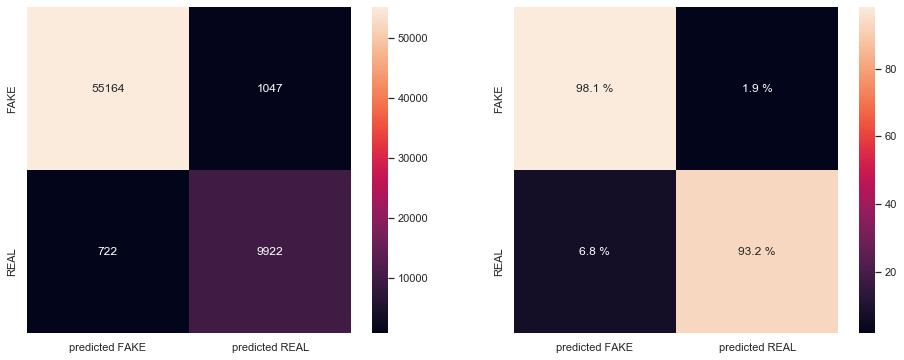

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

conf_matrix, norm_conf_matrix, acc = get_conf_matrix(predicts_df)

sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax[0])
sns.heatmap(norm_conf_matrix, annot=True, fmt='.1f', ax=ax[1])
for t in ax[1].texts: t.set_text(t.get_text() + " %")

print("Acurácia: {:.2f} %".format(acc))
plt.show()

## Resultados Individuais

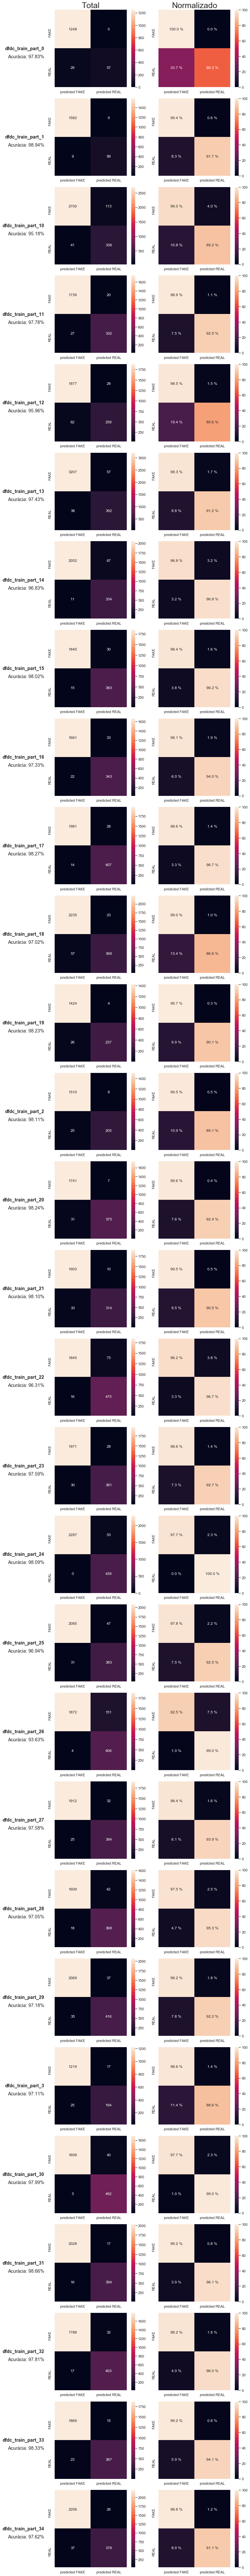

In [40]:
fig, ax = plt.subplots(nrows=len(predicts_df.FOLDER.unique()), ncols=2, figsize=(10,len(predicts_df.FOLDER.unique())*4))

tp = []
tn = []
for i, folder in enumerate(predicts_df.FOLDER.unique()):
    conf_matrix, norm_conf_matrix, acc = get_conf_matrix(predicts_df[predicts_df.FOLDER == folder])
    
    tp.append(norm_conf_matrix.iloc[0][0])
    tn.append(norm_conf_matrix.iloc[1][1])
    
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax[i][0])
    sns.heatmap(norm_conf_matrix, annot=True, fmt='.1f', ax=ax[i][1], vmin=0, vmax=100)
    for t in ax[i][1].texts: t.set_text(t.get_text() + " %")
        
    ax[i][0].annotate(folder, xy=(0, 0.5), xytext=(-ax[i][0].yaxis.labelpad - 5, 0),
                      xycoords=ax[i][0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', weight='bold')
    
    ax[i][0].annotate("Acurácia: {:.2f}%".format(acc), xy=(0, 0.5), xytext=(-ax[i][0].yaxis.labelpad - 5, -25),
                      xycoords=ax[i][0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center')
    
    
ax[0][0].set_title('Total', y=4, fontsize=25)
ax[0][1].set_title('Normalizado', y=4, fontsize=25)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18,15))

ax[0].set_xticks(range(80, 105, 1))
ax[0].set_xlim(80,105)
ax[0].set_title("Distribuição Verdadeiro Positivo por Pasta", fontsize=20)
sns.distplot(tp, ax=ax[0], kde=True, bins=20)
ax[0].annotate("Média: {:.2f}%\nDesvio Padrão: {:.2f}%".format(np.array(tp).mean(), np.array(tp).std()) , xy=(90,0.35), fontsize=15)

plt.xticks(rotation=45)
ax[1].set_xticks(range(80, 105, 1))
ax[1].set_xlim(80,105)
ax[1].set_title("Distribuição Verdadeiro Negativo por Pasta", fontsize=20)
sns.distplot(tn, ax=ax[1], kde=True, bins=20)
ax[1].annotate("Média: {:.2f}%\nDesvio Padrão: {:.2f}%".format(np.array(tn).mean(), np.array(tn).std()) , xy=(85,0.105), fontsize=15)

plt.show()

## Checagem Teste

Agrupa-se os resultados por pasta.

In [78]:
predicts_pf = predicts_df.drop('None', axis=1).groupby(by='FOLDER').sum()
predicts_pf

,True FAKE,True REAL,False FAKE,False REAL
FOLDER,,,,
dfdc_train_part_0,1248,57,0,29
dfdc_train_part_1,1582,99,9,9
dfdc_train_part_10,2700,338,113,41
dfdc_train_part_11,1739,332,20,27
dfdc_train_part_12,1877,258,28,62
dfdc_train_part_13,3207,392,57,38
dfdc_train_part_14,2052,334,67,11
dfdc_train_part_15,1845,383,30,15
dfdc_train_part_16,1661,343,33,22


Vamos carregar a pasta `dfdc_train_part_1`

In [79]:
check_folder = 'dfdc_train_part_1'
predicts_df[(predicts_df['FOLDER'] == check_folder) & (predicts_df['False FAKE']) == 1]

,FOLDER,True FAKE,True REAL,False FAKE,False REAL,None
Video Name,,,,,,
ujslmfluwe.mp4,dfdc_train_part_1,0,0,1,0,0
fakcmcbsax.mp4,dfdc_train_part_1,0,0,1,0,0
juwlfcebod.mp4,dfdc_train_part_1,0,0,1,0,0
hwgfkwzkgx.mp4,dfdc_train_part_1,0,0,1,0,0
vpbhiwdjmd.mp4,dfdc_train_part_1,0,0,1,0,0
zehsfunzox.mp4,dfdc_train_part_1,0,0,1,0,0
nfmzmdtrda.mp4,dfdc_train_part_1,0,0,1,0,0
xhwnzeozrd.mp4,dfdc_train_part_1,0,0,1,0,0
lwmibgydkx.mp4,dfdc_train_part_1,0,0,1,0,0


Vamos checar os 3 primeiros vídeos incorretos de curiosidade. Os vídeos `ujslmfluwe.mp4` e `fakcmcbsax.mp4`.

In [80]:
check_video_path = './Kaggle Dataset/' + check_folder + '/'
check_video_file1 = 'ujslmfluwe.mp4'
check_video_file2 = 'fakcmcbsax.mp4'

In [81]:
metadata = pd.read_json(check_video_path + 'metadata.json').transpose()
metadata

,label,split,original
zumqqvixhu.mp4,FAKE,train,hntguogkqd.mp4
utdlsqfykm.mp4,FAKE,train,nswtvttxre.mp4
mdfndlljvt.mp4,FAKE,train,ptkcmwnfjv.mp4
maktypgsfl.mp4,FAKE,train,objgwnmscm.mp4
pleqihjpif.mp4,FAKE,train,xrhqtmxlvx.mp4
...,...,...,...
qjdtgggqym.mp4,REAL,train,NaN
jzmzdispyo.mp4,REAL,train,NaN
qeaxtxpvyq.mp4,FAKE,train,keioymnobc.mp4
bfeewgzrbr.mp4,FAKE,train,qjdtgggqym.mp4


### Vídeo 1: zumqqvixhu.mp4

In [82]:
showVideo(check_video_path + check_video_file1)

In [83]:
metadata.loc[check_video_file1]

label                 FAKE
split                train
original    oznyyhvzxk.mp4
Name: ujslmfluwe.mp4, dtype: object

In [84]:
showVideo(check_video_path + 'oznyyhvzxk.mp4')

In [85]:
predictor.setVideoPath(check_video_path + check_video_file1)
predictor.getFinalPredict()

(1, 'REAL')

In [86]:
predictor.predicts_tensor.argmax(dim=1)

tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [87]:
doubt = predictor.predicts_tensor.argmax(dim=1).unique(return_counts=True)
doubt[1].tolist(), doubt[1][0].item()/doubt[1][1].item()

([25, 35], 0.7142857142857143)

### Vídeo 2: zumqqvixhu.mp4

Faremos igual para o segundo arquivo...

In [152]:
showVideo(check_video_path + check_video_file2)

In [ ]:
metadata.loc[check_video_file2]

In [133]:
showVideo(check_video_path + 'fakcmcbsax.mp4')

In [ ]:
predictor.setVideoPath(check_video_path + check_video_file2)
predictor.getFinalPredict()

In [ ]:
predictor.predicts_tensor.argmax(dim=1)

In [ ]:
doubt = predictor.predicts_tensor.argmax(dim=1).unique(return_counts=True)
doubt[1].tolist(), doubt[1][0].item()/doubt[1][1].item()

## Teste na minha tentativa de DeepFake

In [14]:
path_fake_dfl = '../../Downloads/Setups/DeepFaceLab/DeepFaceLab_NVIDIA/workspace/result.mp4'
path_real1_dfl = '../../Downloads/Setups/DeepFaceLab/DeepFaceLab_NVIDIA/workspace/data_dst.mp4'
path_real2_dfl = '../../Downloads/Setups/DeepFaceLab/DeepFaceLab_NVIDIA/workspace/data_src.mp4'
predictor.setVideoPath(path_fake_dfl)

In [15]:
showVideo(path_fake_dfl)

In [ ]:
predictor.getFinalPredict(), F.softmax(predictor.predicts_tensor, dim=1).argmax(dim=1).unique(return_counts=True)

In [17]:
predictor.setVideoPath(path_real1_dfl)

In [18]:
showVideo(path_real1_dfl)

In [ ]:
predictor.getFinalPredict(), F.softmax(predictor.predicts_tensor, dim=1).argmax(dim=1).unique(return_counts=True)

In [20]:
predictor.setVideoPath(path_real2_dfl)

In [113]:
showVideo(path_real2_dfl)

In [ ]:
predictor.getFinalPredict(), F.softmax(predictor.predicts_tensor, dim=1).argmax(dim=1).unique(return_counts=True)